# Прогнозирование оттока клиентов
Оператор связи хочет научиться прогнозировать отток клиентов. 
Если пользователь устал и уходит, ему предлагаются промокоды и специальные условия. 
Нужно научиться определять таких клиентов.

## Загрузка данных
Загрузим данные и проведем первичный анализ.

In [1]:
# фундаментальные заявления
import matplotlib.pyplot as plt
import numpy             as np
import pandas            as pd
import seaborn           as sns

from catboost import CatBoost, CatBoostClassifier
from catboost import Pool

from sklearn.ensemble        import RandomForestClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.metrics         import accuracy_score, plot_roc_curve
from sklearn.metrics         import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing   import OrdinalEncoder, StandardScaler

In [2]:
# сначала загрузим
contract = pd.read_csv('')
personal = pd.read_csv('')
internet = pd.read_csv('')
phone = pd.read_csv('')

Вставим функцию на все случаи жизни

In [3]:
def exploring(df):
    print('----------- Описание данных -----------')
    display(df.head(10))
    print('---------------------------------------')
    display(df.info())
    print('---------------------------------------')
    display(df.describe().T)
    print('---------------------------------------')
    display(df.describe(include=[object]).T)
    print('---------------------------------------')
    for column in df.columns:
        print('-------------------------')
        print(column,' : кол-во 0:', df[df[column] == 0][column].count(),
        ', процент 0:', round(df[df[column] == 0][column].count()/len(df)*100, 2),'%', 
        ', кол-во NaN:', df[column].isna().sum(), 
        ', процент NaN:', round(df[column].isna().sum()/len(df)*100, 2),'%')
    print('---------------------------------------')
    print('Количество строк-дубликатов:', df.duplicated().sum())

Применим ее на наших данных

In [4]:
datasets = [contract, personal, internet, phone]
for df in datasets:
    print('++++++++++++++++++++++++++++++++++++')
    exploring(df)

++++++++++++++++++++++++++++++++++++
----------- Описание данных -----------


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
5,9305-CDSKC,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.65,820.5
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,301.9
8,7892-POOKP,2017-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,104.80,3046.05
9,6388-TABGU,2014-12-01,No,One year,No,Bank transfer (automatic),56.15,3487.95


---------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

---------------------------------------


,count,mean,std,min,25%,50%,75%,max
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75


---------------------------------------


,count,unique,top,freq
customerID,7043,7043,6145-NNPNO,1
BeginDate,7043,77,2014-02-01,366
EndDate,7043,5,No,5174
Type,7043,3,Month-to-month,3875
PaperlessBilling,7043,2,Yes,4171
PaymentMethod,7043,4,Electronic check,2365
TotalCharges,7043,6531,,11


---------------------------------------
-------------------------
customerID  : кол-во 0: 0 , процент 0: 0.0 % , кол-во NaN: 0 , процент NaN: 0.0 %
-------------------------
BeginDate  : кол-во 0: 0 , процент 0: 0.0 % , кол-во NaN: 0 , процент NaN: 0.0 %
-------------------------
EndDate  : кол-во 0: 0 , процент 0: 0.0 % , кол-во NaN: 0 , процент NaN: 0.0 %
-------------------------
Type  : кол-во 0: 0 , процент 0: 0.0 % , кол-во NaN: 0 , процент NaN: 0.0 %
-------------------------
PaperlessBilling  : кол-во 0: 0 , процент 0: 0.0 % , кол-во NaN: 0 , процент NaN: 0.0 %
-------------------------
PaymentMethod  : кол-во 0: 0 , процент 0: 0.0 % , кол-во NaN: 0 , процент NaN: 0.0 %
-------------------------
MonthlyCharges  : кол-во 0: 0 , процент 0: 0.0 % , кол-во NaN: 0 , процент NaN: 0.0 %
-------------------------
TotalCharges  : кол-во 0: 0 , процент 0: 0.0 % , кол-во NaN: 0 , процент NaN: 0.0 %
---------------------------------------
Количество строк-дубликатов: 0
++++++++++++++++++++

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
5,9305-CDSKC,Female,0,No,No
6,1452-KIOVK,Male,0,No,Yes
7,6713-OKOMC,Female,0,No,No
8,7892-POOKP,Female,0,Yes,No
9,6388-TABGU,Male,0,No,Yes


---------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

---------------------------------------


,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,7043.0,0.162147,0.368612,0.0,0.0,0.0,0.0,1.0


---------------------------------------


,count,unique,top,freq
customerID,7043,7043,6145-NNPNO,1
gender,7043,2,Male,3555
Partner,7043,2,No,3641
Dependents,7043,2,No,4933


---------------------------------------
-------------------------
customerID  : кол-во 0: 0 , процент 0: 0.0 % , кол-во NaN: 0 , процент NaN: 0.0 %
-------------------------
gender  : кол-во 0: 0 , процент 0: 0.0 % , кол-во NaN: 0 , процент NaN: 0.0 %
-------------------------
SeniorCitizen  : кол-во 0: 5901 , процент 0: 83.79 % , кол-во NaN: 0 , процент NaN: 0.0 %
-------------------------
Partner  : кол-во 0: 0 , процент 0: 0.0 % , кол-во NaN: 0 , процент NaN: 0.0 %
-------------------------
Dependents  : кол-во 0: 0 , процент 0: 0.0 % , кол-во NaN: 0 , процент NaN: 0.0 %
---------------------------------------
Количество строк-дубликатов: 0
++++++++++++++++++++++++++++++++++++
----------- Описание данных -----------


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
5,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
6,1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
7,6713-OKOMC,DSL,Yes,No,No,No,No,No
8,7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes
9,6388-TABGU,DSL,Yes,Yes,No,No,No,No


---------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

---------------------------------------


,count,unique,top,freq
customerID,5517,5517,6145-NNPNO,1
InternetService,5517,2,Fiber optic,3096
OnlineSecurity,5517,2,No,3498
OnlineBackup,5517,2,No,3088
DeviceProtection,5517,2,No,3095
TechSupport,5517,2,No,3473
StreamingTV,5517,2,No,2810
StreamingMovies,5517,2,No,2785


---------------------------------------


,count,unique,top,freq
customerID,5517,5517,6145-NNPNO,1
InternetService,5517,2,Fiber optic,3096
OnlineSecurity,5517,2,No,3498
OnlineBackup,5517,2,No,3088
DeviceProtection,5517,2,No,3095
TechSupport,5517,2,No,3473
StreamingTV,5517,2,No,2810
StreamingMovies,5517,2,No,2785


---------------------------------------
-------------------------
customerID  : кол-во 0: 0 , процент 0: 0.0 % , кол-во NaN: 0 , процент NaN: 0.0 %
-------------------------
InternetService  : кол-во 0: 0 , процент 0: 0.0 % , кол-во NaN: 0 , процент NaN: 0.0 %
-------------------------
OnlineSecurity  : кол-во 0: 0 , процент 0: 0.0 % , кол-во NaN: 0 , процент NaN: 0.0 %
-------------------------
OnlineBackup  : кол-во 0: 0 , процент 0: 0.0 % , кол-во NaN: 0 , процент NaN: 0.0 %
-------------------------
DeviceProtection  : кол-во 0: 0 , процент 0: 0.0 % , кол-во NaN: 0 , процент NaN: 0.0 %
-------------------------
TechSupport  : кол-во 0: 0 , процент 0: 0.0 % , кол-во NaN: 0 , процент NaN: 0.0 %
-------------------------
StreamingTV  : кол-во 0: 0 , процент 0: 0.0 % , кол-во NaN: 0 , процент NaN: 0.0 %
-------------------------
StreamingMovies  : кол-во 0: 0 , процент 0: 0.0 % , кол-во NaN: 0 , процент NaN: 0.0 %
---------------------------------------
Количество строк-дубликатов: 0
+

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
5,7892-POOKP,Yes
6,6388-TABGU,No
7,9763-GRSKD,No
8,7469-LKBCI,No
9,8091-TTVAX,Yes


---------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

---------------------------------------


,count,unique,top,freq
customerID,6361,6361,6145-NNPNO,1
MultipleLines,6361,2,No,3390


---------------------------------------


,count,unique,top,freq
customerID,6361,6361,6145-NNPNO,1
MultipleLines,6361,2,No,3390


---------------------------------------
-------------------------
customerID  : кол-во 0: 0 , процент 0: 0.0 % , кол-во NaN: 0 , процент NaN: 0.0 %
-------------------------
MultipleLines  : кол-во 0: 0 , процент 0: 0.0 % , кол-во NaN: 0 , процент NaN: 0.0 %
---------------------------------------
Количество строк-дубликатов: 0


Итак, пропусков нет, нулей нет.

В датасетах представлена информация о 7043 клиентах телеком-компании.

Что понятно из этих данных:

О самих данных:
* в таблице `contract` неправильные типы данных у признаков `BeginDate`, `EndDate`, `TotalCharges`;
* в таблице `personal` классы клиентов указаны по-разному (1/0 или Yes/No).

О клиентах
* 1869 клиентов больше не клиенты;
* Самая распростаненная схема оплаты - ежемесячная, более половины клиентов выбрали ее.
* средний клиент тратит в месяц ~65 единиц денег;
* женщин и мужчин примерно поровну;
* Иждивенцев чуть более 2000;
* 5517 клиентов подключены к интернету, чуть более половины - по оптике;
* самые популярные дополнительные услуги являются стриминг фильмов и интернет-телевидение, их подключили около половины пользователей;
* меньше всего клиентов платят за выделенную линию саппорта и блокировку небезопасных сайтов;
* 6361 клиент использует стационарный телефон, из них ~3000 - несколько линий.


Во всех таблицах в явном виде отсутствует целевой признак, а именно, ушел ли клиент. Этот признак можно сгенерировать из столбца `EndDate` таблицы `contract`, который говорит о завершении контракта.
Кроме этого, на мой взгляд, было бы полезно посчитать продолжительность клиентских контрактов, в том числе актуальную, для незавершенных.




## Анализ данных
Необходимо изучить данные о клиентах и взаимосвязь параметров и целевого признака.

### Исправление недочетов
Здесь поправим типы данных. Начнем с таблицы `contract`

In [5]:
# разберемся какие значения в TotalCharge, т.к. не получается заменить строку на вещественное число
contract.sort_values('TotalCharges').head(15)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
6754,2775-SEFEE,2020-02-01,No,Two year,Yes,Bank transfer (automatic),61.90,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,


Всего 11 значений мешают нам жить. Все пользователи двухгодичных контрактов, дата подключения которых соответствует дате выгрузки. Вероятно, они еще ничего не заплатили, поэтому заменим значения на нули

In [6]:
contract['TotalCharges'] = contract['TotalCharges'] \
    .replace(to_replace=' ',
             value='0') \
    .astype('float')

In [7]:
contract.sort_values('TotalCharges').head(15)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,0.00
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,0.00
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,0.00
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,0.00
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,0.00
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,0.00
6754,2775-SEFEE,2020-02-01,No,Two year,Yes,Bank transfer (automatic),61.90,0.00
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,0.00
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,0.00
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,0.00


Создадим столбец с целевым признаком.

In [8]:
contract['Exited'] = contract['EndDate'].apply(lambda x: 0 if x == 'No' else 1)

Очень хорошо. Теперь займемся превращением `EndDate` в `Datetime`, а заодно и `BeginDate` поправим

In [9]:
# Заменим No на дату выгрузки
contract['EndDate'] = pd.to_datetime(contract['EndDate']
                                     .replace(to_replace='No',
                                              value='2020-02-01'))

# заменим тип в BeginDate
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'])
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Exited
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,0
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1


Создадим новый признак, отражающий продолжительность контрактов. После этого дропнем столбцы `BeginDate` и `EndDate` за отсутствием необходимости в первом и утечке ЦП во втором.

In [10]:
contract['ContractDuration'] = contract['EndDate'] - contract['BeginDate']
contract['ContractDuration'] = contract['ContractDuration'].dt.days
contract = contract.drop(['BeginDate', 'EndDate'], axis=1)

contract.head()

,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Exited,ContractDuration
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,29.85,0,31
1,5575-GNVDE,One year,No,Mailed check,56.95,1889.50,0,1036
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,108.15,1,61
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1840.75,0,1371
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,151.65,1,61


### Объединение таблиц, предобработка данных
Объединим таблицы по признаку `customerID`

In [11]:
df = contract.merge(personal, on='customerID', how='left')\
.merge(internet, on='customerID', how='left')\
.merge(phone, on='customerID', how='left')

df.head()

,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Exited,ContractDuration,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,29.85,0,31,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,One year,No,Mailed check,56.95,1889.50,0,1036,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,108.15,1,61,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1840.75,0,1371,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,151.65,1,61,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


Все удачно складывается. После соединения таблиц становится понятным, что отсутствуют признаки наличия телефонной линии или интернета. Для интернета мы попробуем просто добавить третью категорию `No` в столбец `InternetService`. Это мы сделаем вместе со всеобщей заменой `Nan` на `No`. C `MultipleLines` в телефонии такое не прокатит. `No` там уже есть, поэтому выедлим еще один признак, касающийся использования телефона.

In [12]:
# создадим столбец PhoneService
df['PhoneService'] = df['MultipleLines'].apply(lambda x: 'Yes' if x in ['No', 'Yes'] else 'No')
len(df[df['PhoneService'] == 'No'])

682

In [13]:
# заполним пропуски
df = df.fillna('No')
df.head()

,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Exited,ContractDuration,gender,SeniorCitizen,...,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,PhoneService
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,29.85,0,31,Female,0,...,No,DSL,No,Yes,No,No,No,No,No,No
1,5575-GNVDE,One year,No,Mailed check,56.95,1889.50,0,1036,Male,0,...,No,DSL,Yes,No,Yes,No,No,No,No,Yes
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,108.15,1,61,Male,0,...,No,DSL,Yes,Yes,No,No,No,No,No,Yes
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1840.75,0,1371,Male,0,...,No,DSL,Yes,No,Yes,Yes,No,No,No,No
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,151.65,1,61,Female,0,...,No,Fiber optic,No,No,No,No,No,No,No,Yes


### Исследование данных
Посмотрим на то, кто вообще уходит и как распределены данные по ежемесячной стоимости и длительности контракта для тех, кто ушел, и кто - нет.

Начнем c изучения распределений.

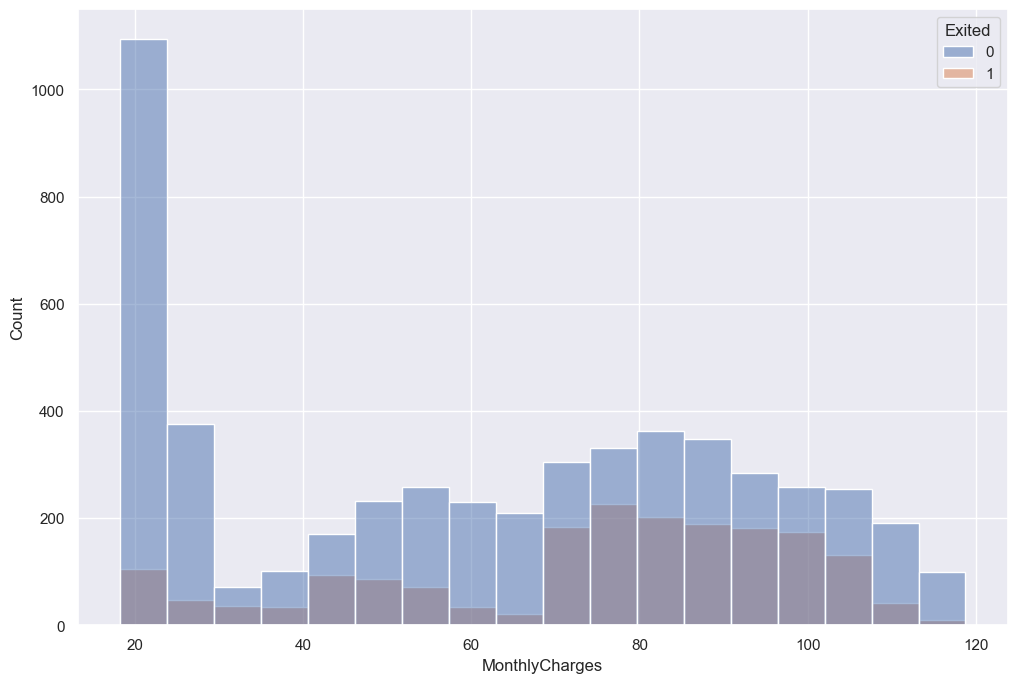

In [14]:
sns.set(rc={'figure.figsize':(12, 8)})
sns.histplot(data=df, x='MonthlyCharges', hue="Exited");

Совсем не колокол. Те, чей ежемесячный платеж невелик, уходят реже всех. Посмотрим, какие у нас получаются крайности.

In [15]:
df.sort_values('MonthlyCharges')

,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Exited,ContractDuration,gender,SeniorCitizen,...,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,PhoneService
3719,6823-SIDFQ,One year,No,Credit card (automatic),18.25,534.70,0,853,Male,0,...,No,No,No,No,No,No,No,No,No,Yes
1529,9764-REAFF,Two year,No,Bank transfer (automatic),18.40,1057.85,0,1798,Female,0,...,No,No,No,No,No,No,No,No,No,Yes
6652,0827-ITJPH,Two year,Yes,Credit card (automatic),18.55,689.00,0,1095,Male,0,...,No,No,No,No,No,No,No,No,No,Yes
6906,9945-PSVIP,Two year,Yes,Mailed check,18.70,383.65,0,761,Female,0,...,Yes,No,No,No,No,No,No,No,No,Yes
1156,0621-CXBKL,Two year,No,Mailed check,18.70,1005.70,0,1614,Female,0,...,No,No,No,No,No,No,No,No,No,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5127,8199-ZLLSA,One year,Yes,Bank transfer (automatic),118.35,7804.15,1,2040,Male,0,...,No,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes
3894,5989-AXPUC,Two year,No,Mailed check,118.60,7990.05,0,2071,Female,0,...,No,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes
4804,5734-EJKXG,One year,Yes,Electronic check,118.60,7365.70,0,1857,Female,0,...,No,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes
2115,8984-HPEMB,Two year,Yes,Electronic check,118.65,8477.60,0,2163,Female,0,...,No,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes


Примерно 18 условных единиц платят люди, отдающие предпочтения дисковому телефону вместо мессенджеров. На 100 единиц больше тратят люди, оплачивающие все доступные сервисы.

А как обстоят дела с длительностью?

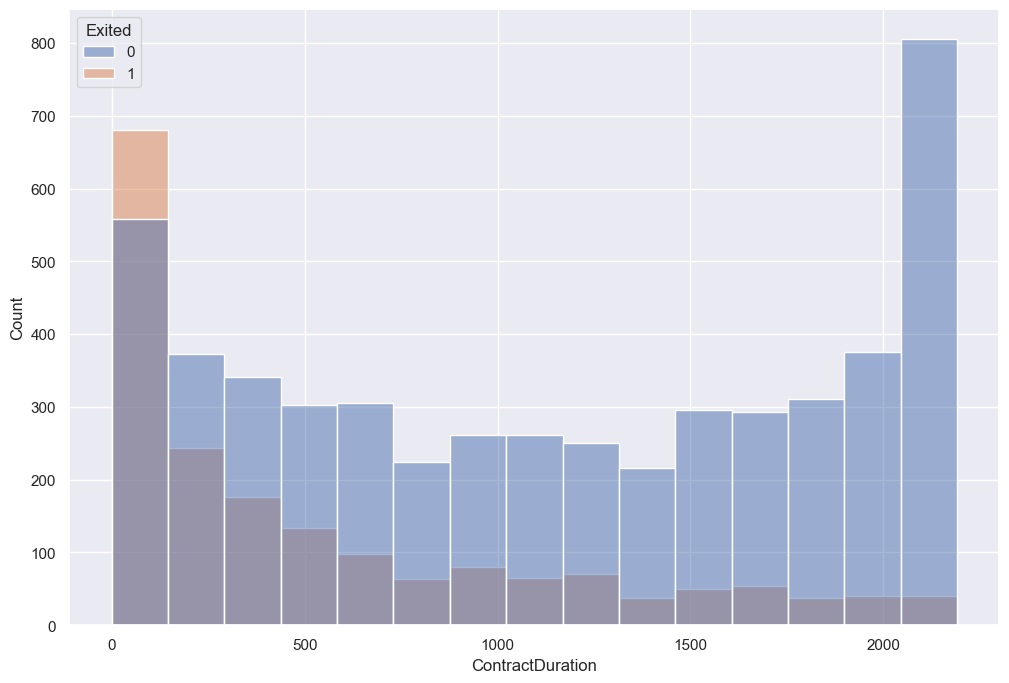

In [16]:
sns.histplot(data=df, x='ContractDuration', hue="Exited");

Большинство отваливаются вначале пути. Кажется, нужно предлагать более выгодные условия для новых пользователей. 

Посмотрим, люди с каким типом контрактов чаще всего уходят

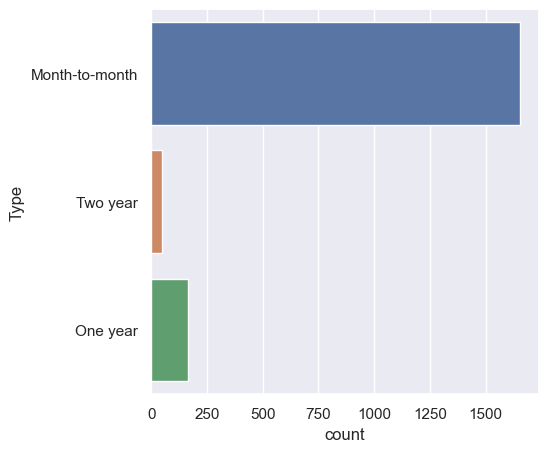

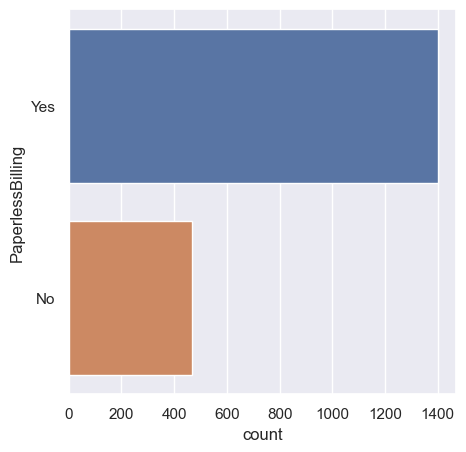

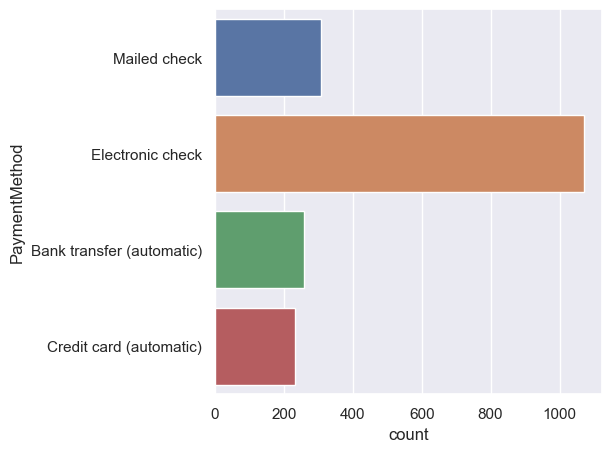

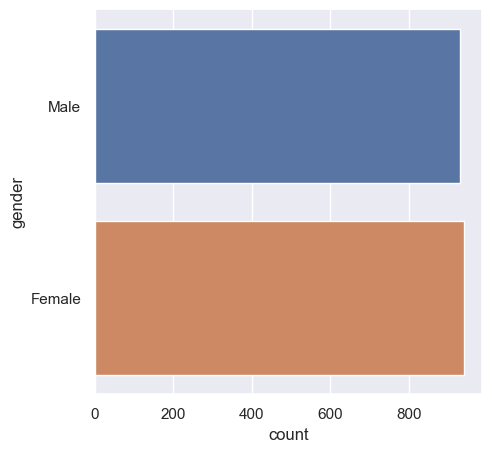

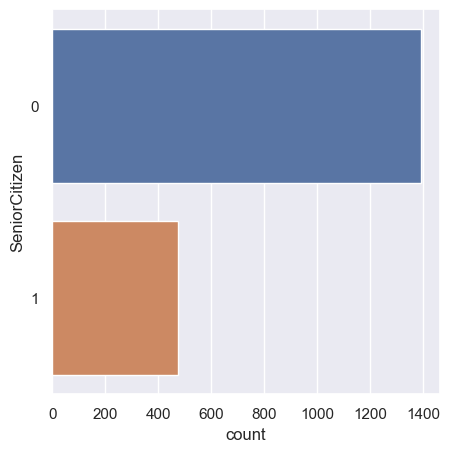

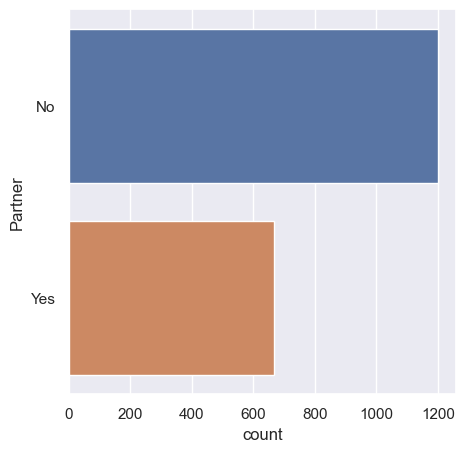

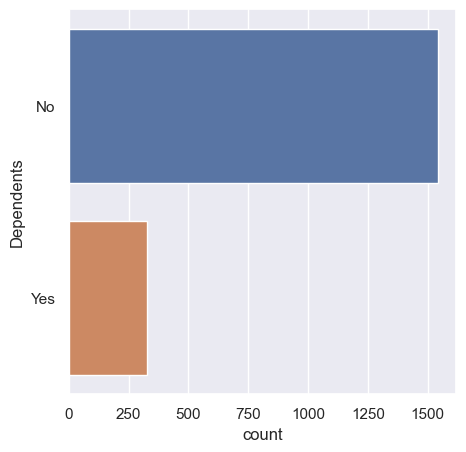

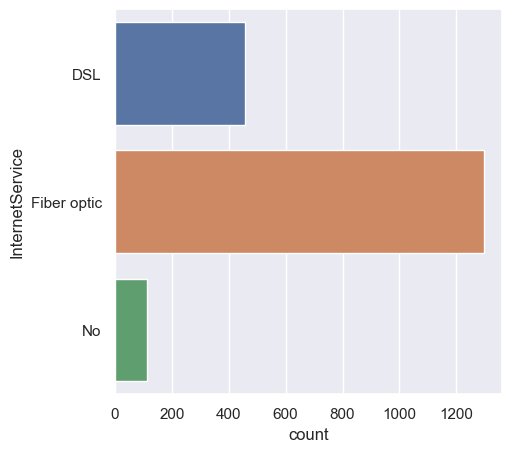

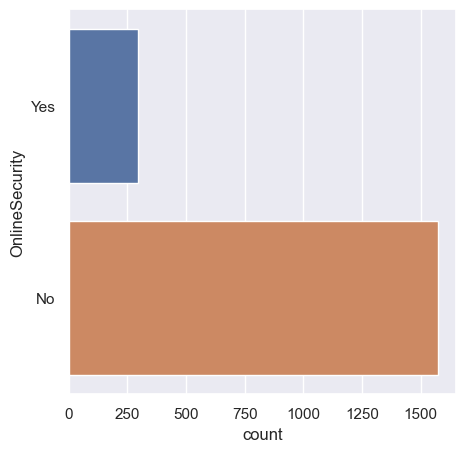

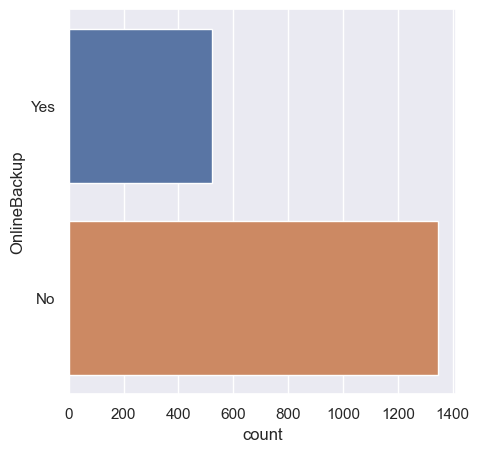

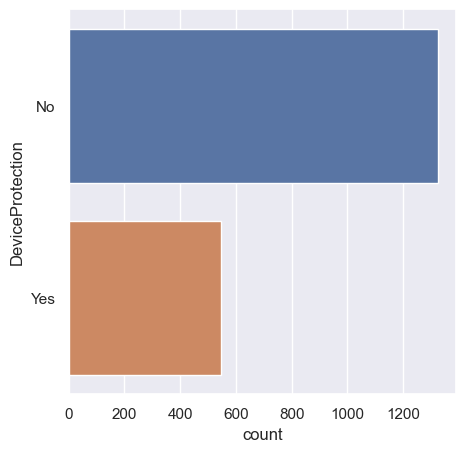

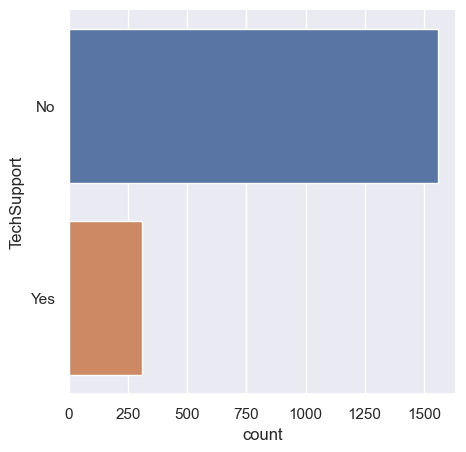

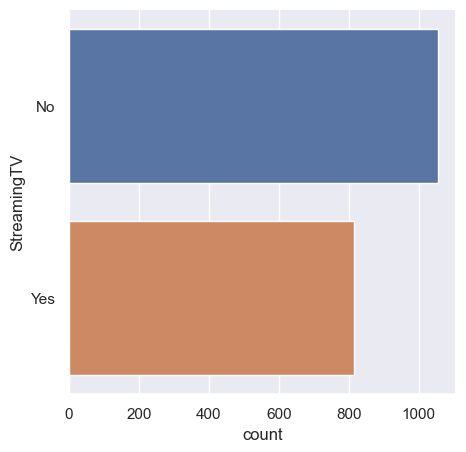

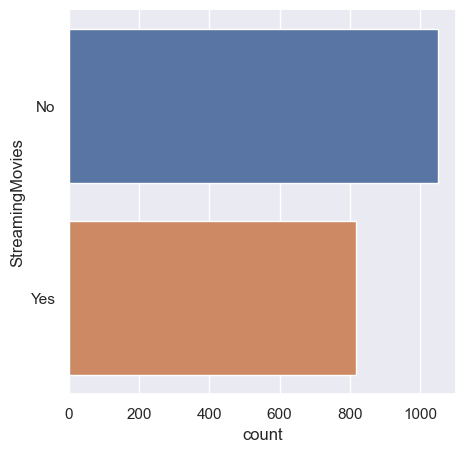

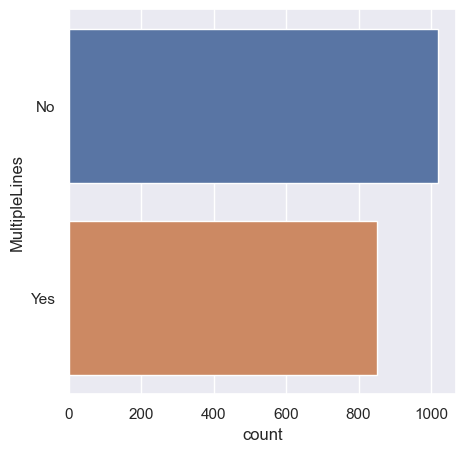

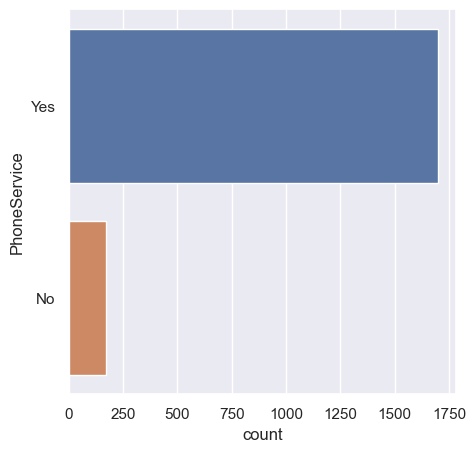

In [17]:
cols_of_interest = df \
                    .drop(['MonthlyCharges', 'TotalCharges', 
                         'Exited', 'ContractDuration'], axis=1) \
                    .columns[1:]


sns.set(rc={'figure.figsize':(5, 5)})
for feature in cols_of_interest:
     plt.figure()
     sns.countplot(y=feature, data=df[df['Exited'] == 1]);

Чаще всего уходят клиенты с ежемесячной оплатой и реже всех с продлением раз в два года. Кроме того, люди с оптической линией, блокировщиком рекламы и резервным хранилищем также с большей вероятностью покинут компанию.

### Подготовка данных к проверке корреляции.
Заменим Y/N на 1/0

In [18]:
binary_columns = ['PaperlessBilling', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'MultipleLines', 'PhoneService']

encoder = OrdinalEncoder()

df[binary_columns] = encoder.fit_transform(df[binary_columns]).astype('int')

df.head()

,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Exited,ContractDuration,gender,SeniorCitizen,...,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,PhoneService
0,7590-VHVEG,Month-to-month,1,Electronic check,29.85,29.85,0,31,0,0,...,0,DSL,0,1,0,0,0,0,0,0
1,5575-GNVDE,One year,0,Mailed check,56.95,1889.50,0,1036,1,0,...,0,DSL,1,0,1,0,0,0,0,1
2,3668-QPYBK,Month-to-month,1,Mailed check,53.85,108.15,1,61,1,0,...,0,DSL,1,1,0,0,0,0,0,1
3,7795-CFOCW,One year,0,Bank transfer (automatic),42.30,1840.75,0,1371,1,0,...,0,DSL,1,0,1,1,0,0,0,0
4,9237-HQITU,Month-to-month,1,Electronic check,70.70,151.65,1,61,0,0,...,0,Fiber optic,0,0,0,0,0,0,0,1


In [19]:
# Теперь дропнем id клиентов
df = df.drop('customerID', axis=1)

# закодируем оставшиеся признаки без drop_first для корреляции, чтобы ничего не упустить
df_for_corr = pd.get_dummies(df)

# для моделей допишем drop_first
df = pd.get_dummies(df, drop_first=True)

### Проверка на мультиколлениарность
Для этого построим хитмэп корреляций. Матрицу диаграмм рассеяния по ушедшим/оставшимся строить не будем, признаков слишком много, а основные зависимости мы обозгначили в предыдущем шаге.

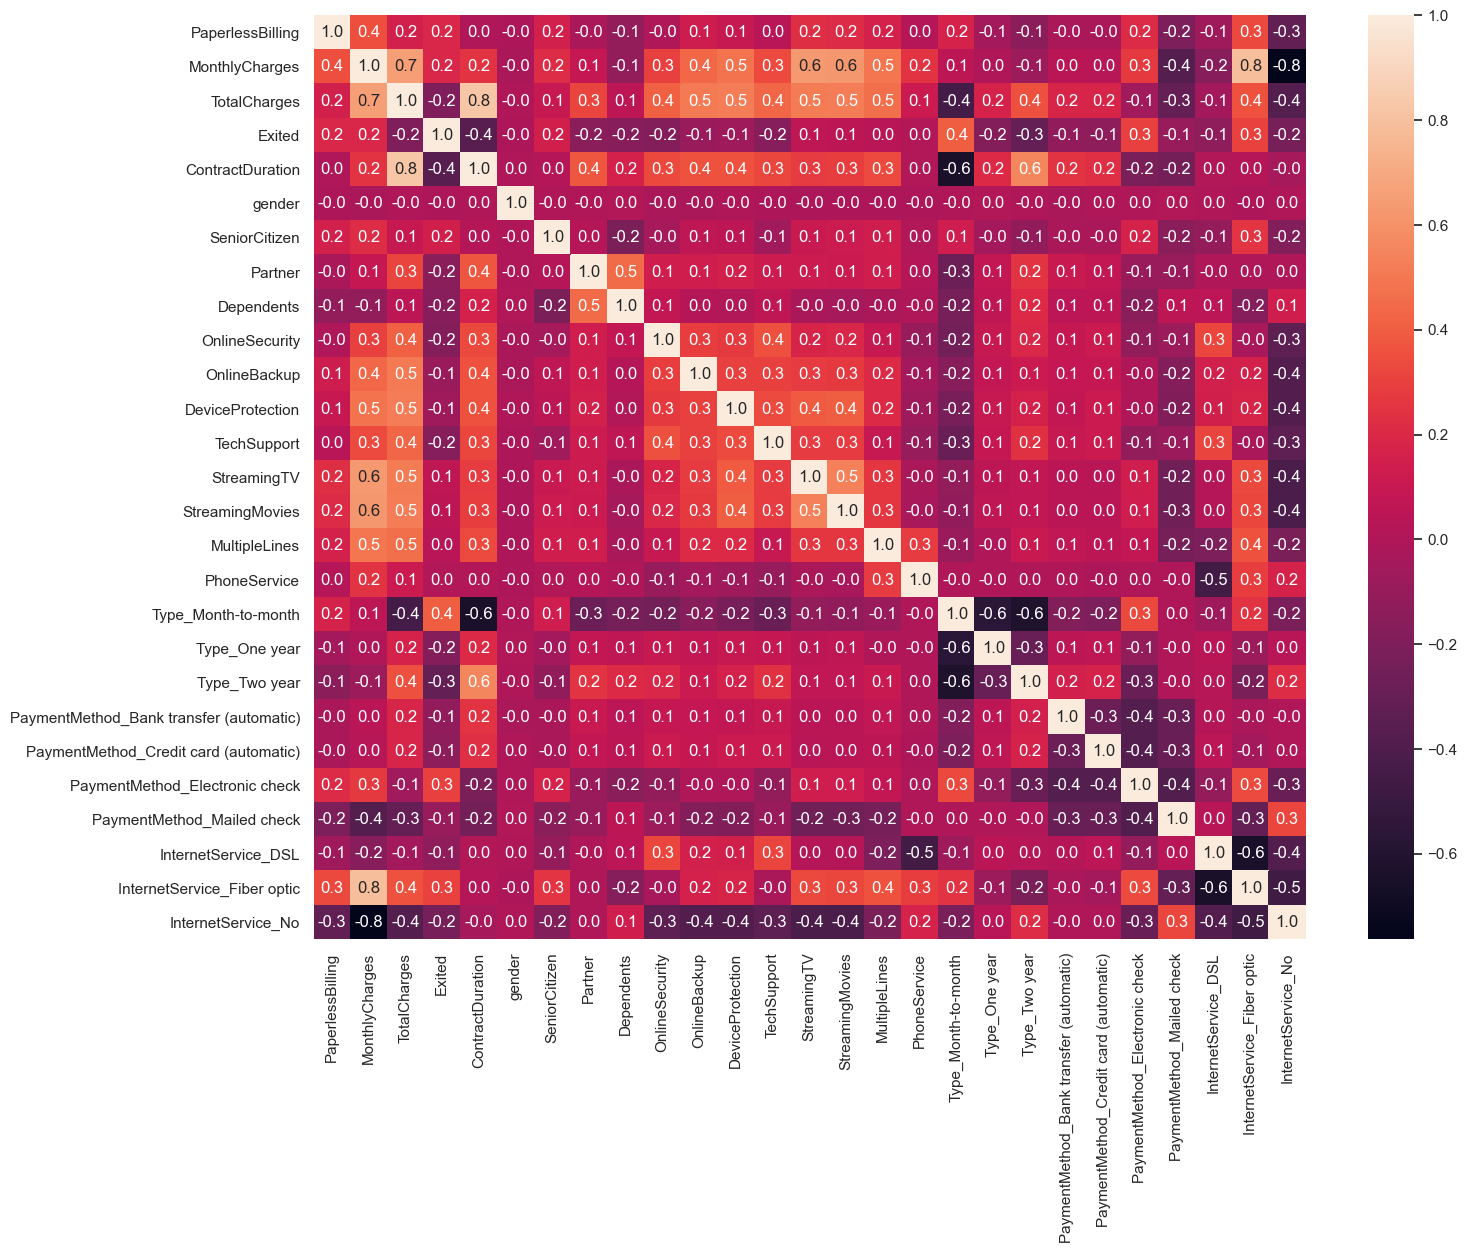

In [20]:
sns.set(rc={'figure.figsize':(16, 12)})
ax = sns.heatmap(df_for_corr.corr(), annot=True, fmt='.1f');

Есть три самых сильных связи между признаками:
* Ежемесячный платеж и отсутствие интернета;
* Ежемесячный платеж и оптическая линия;
* Общая сумма платежей и длительность контракта.
    
В целом, ничего удивительного. Очевидно, что наличие оптической линии очень явно повлияет на стоимость услуг. Отсутствие интернета, разумеется тоже. Логика подсказывает и то, что чем дольше клиент является абонентом, тем больше в сумме он занес денег в компанию.

Пока оставим все как есть. Если будет результаты обучения окажутся неудовлетворительными, оставим по одному признаку из каждой пары.

### Подводим итоги анализа
Потребовалась предобработка данных и создание более информативных фич, а также удаление несущественных. В частности, был создан столбец с длительностью контрактов, и удалены стобцы с исходными данными для этого. После объединения таблиц была добавлена информация о наличии или отсутствии интернета или телефонии у клиента, а также запонены пропуски.

Анализ показал, что чаще всего клиенты уходят в первые полгода, а также те, кто выбрал тип контраката `Month-to-month`.

В данных есть взаимосвязи, но их влияние на качестов модели предстоит выяснить.

Возможно, некоторые признаки придется сгрупировать, например, наличие допонительных услуг или интернета в целом.

## Предобработка данных для обучения моделей
Начнем с разделения выдедения фич и целевого признака, затем разделим на трейн и тест.

In [21]:
X = df.drop('Exited', axis=1)
y = df['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5282, 23), (1761, 23), (5282,), (1761,))

Теперь скалирование количественных признаков. Чего только не сделаешь ради логистической регрессии.

In [22]:
scaler = StandardScaler()
num_features = ['MonthlyCharges', 'TotalCharges', 'ContractDuration']
X_train[num_features] = scaler.fit_transform(X_train[num_features])
X_test[num_features] = scaler.transform(X_test[num_features])

X_train.head()

C:\Users\luche\AppData\Local\Temp\ipykernel_12424\3166512909.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[num_features] = scaler.fit_transform(X_train[num_features])
c:\Users\luche\anaconda3\envs\practicum\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\luche\AppData\Local\Temp\ipykernel_12424\3166512909.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

,PaperlessBilling,MonthlyCharges,TotalCharges,ContractDuration,gender,SeniorCitizen,Partner,Dependents,OnlineSecurity,OnlineBackup,...,StreamingMovies,MultipleLines,PhoneService,Type_One year,Type_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_Fiber optic,InternetService_No
6607,1,-1.310046,-0.997066,-1.282970,1,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
2598,1,0.344832,-0.776794,-1.036117,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,1,0
2345,1,-1.484331,-0.970529,-1.159543,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
4093,1,0.373049,-0.031721,-0.139933,0,0,0,0,0,0,...,0,1,1,0,0,1,0,0,1,0
693,1,0.343172,-0.888892,-1.201133,0,0,0,0,0,0,...,0,1,1,0,0,1,0,0,1,0


### Альтернатива анализу
Если не особо интересно погружаться в анализ данных и самостоятельно искать закономерности, можно пойти простым и быстрым путем - оценить важность признаков. Оценим при помози встроенных средств библиотеки CatBoost, а затем визуализируем.

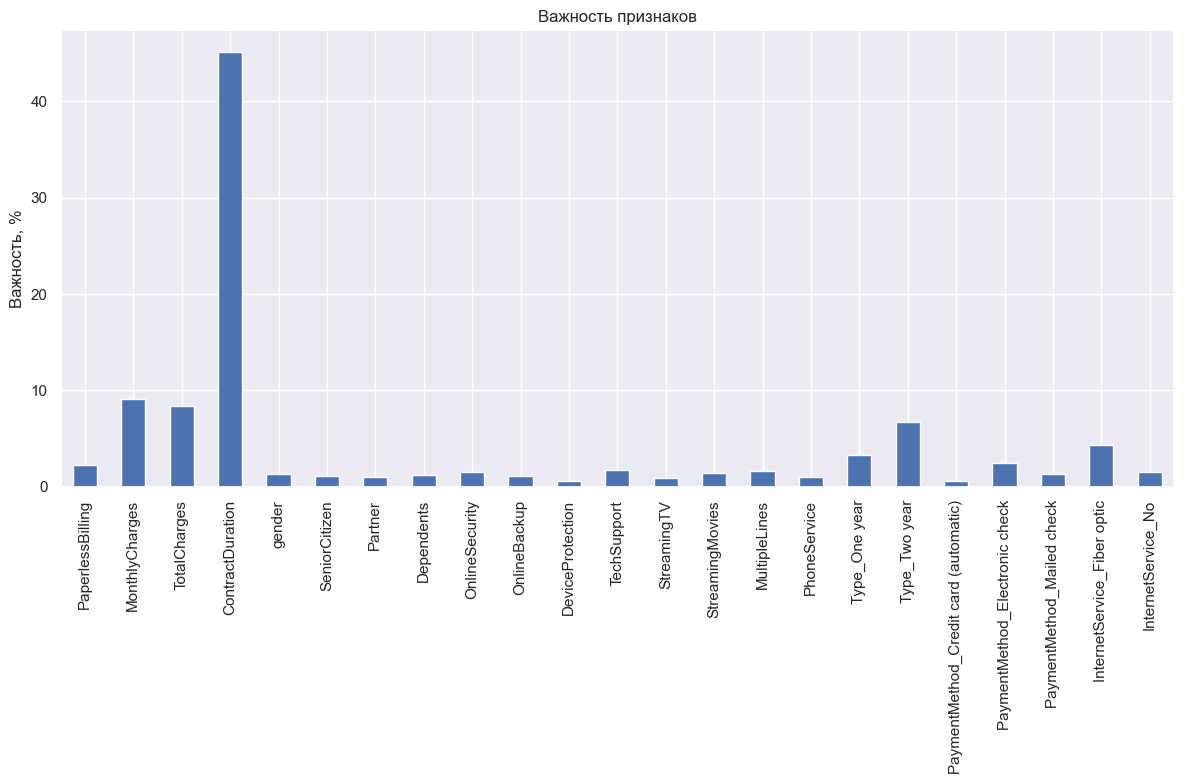

In [23]:
# определим категориальные признаки
cat_features = ['PaperlessBilling', 'gender', 'SeniorCitizen', 
                'Partner', 'Dependents', 'OnlineSecurity', 
                'OnlineBackup', 'DeviceProtection', 'TechSupport',
                'StreamingTV', 'StreamingMovies', 'MultipleLines', 
                'PhoneService', 'Type_One year', 'Type_Two year',
                'PaymentMethod_Credit card (automatic)', 
                'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
                'InternetService_Fiber optic', 'InternetService_No']

# создадим тренировочный пул
train_data = Pool(data=X_train,
                  label=y_train,
                  cat_features=cat_features)

# обучим CatBoost
cb_fi = CatBoostClassifier(verbose=False, random_seed=42, eval_metric='AUC')
cb_fi.fit(train_data)

# создадим датафрейм с признаками и их важностью
df_fi = pd.Series(cb_fi.get_feature_importance(),
                         X_train.columns)

# построим барплот
fig, ax = plt.subplots(figsize=(12,8))
df_fi.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность, %')
fig.tight_layout()


Длительность контракта вне конкуренции. С одним этим признаком мы получим хороший результат, но там мы делать не будем. Обучим модели без учета важности признаков, но отдельно пройдемся кэтбустом, оставив 5-6 самых важных признаков и проверим модель на предмет действенности данного метода.

## Моделирование
Рассмотрим три модели:
* Логистическую регрессию
* Случайный лес
* CatBoost

Несмотря на несбалансированность выборки, будем использовать стандартные средства моделей для автокорректировки дисбаланса
### Логистическая регрессия
Начнем с простого

In [24]:
# выделим параметры для перебора
lr_param_grid = {'C': [0.01, 0.1, 1.0, 10, 100],
             'tol': [0.0001, 0.001, 0.01, 0.1, 1]}

# объявим модель
lr = LogisticRegression(class_weight='balanced', 
                        max_iter=1000, 
                        random_state = 42)

Переберем параметры

In [25]:
lr_grid = GridSearchCV(lr, lr_param_grid, scoring='roc_auc')
lr_grid.fit(X_train, y_train)
lr_grid.best_estimator_

LogisticRegression(C=10, class_weight='balanced', max_iter=1000,
                   random_state=42)

Напишем функцию для создания файла с предсказаниями модели и рассчета accuracy и ROC-AUC и ConfusionMatrix

In [26]:

def scoring(model, X, y):

    # предсказания
    prediction = model.predict(X)

    # выведем качество и график ROC-AUC
    print('Accuracy =', round(accuracy_score(y, prediction), 2))
    plot_roc_curve(model, X, y)

    # интереса ради посмотрим на матрицу ошибок    
    cm = confusion_matrix(y, prediction, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=model.classes_)
    disp.plot()

    plt.show()

Посмотрим на метрику ROC-AUC по результатам кросс-валидации и перебора параметров.

Accuracy = 0.74


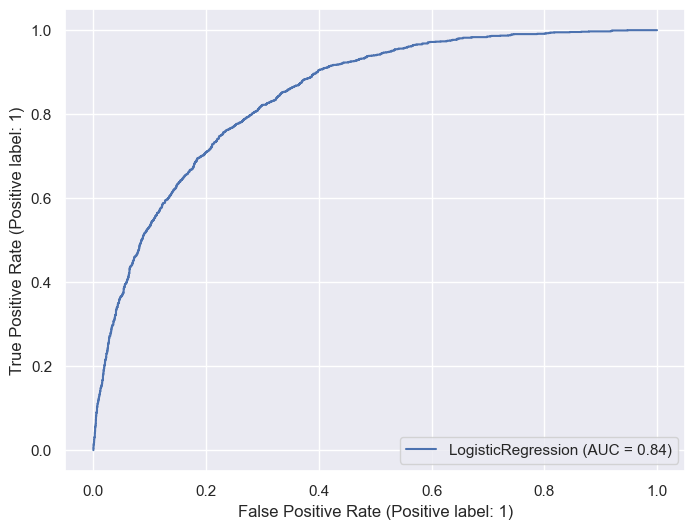

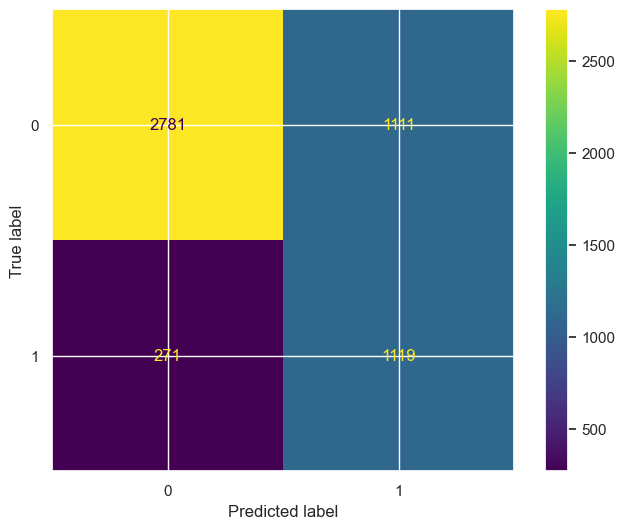

In [27]:
sns.set(rc={'figure.figsize':(8, 6)});
scoring(lr_grid.best_estimator_, X_train, y_train)

Результат довольно неплохой

### Случайный лес
Повторим те же действия

In [28]:
# выделим параметры для перебора
rfc_param_grid = {'max_depth': range(1, 10),
                  'min_samples_split': range(2, 10, 2),
                  'max_features': ['log2', 'sqrt']}

# объявим модель
rfc = RandomForestClassifier(n_estimators=20, random_state=42)

Переберем параметры

In [29]:
rfc_grid = GridSearchCV(rfc, rfc_param_grid, scoring='roc_auc')
rfc_grid.fit(X_train, y_train)
rfc_grid.best_estimator_

RandomForestClassifier(max_depth=9, max_features='log2', min_samples_split=4,
                       n_estimators=20, random_state=42)

Посмотрим на метрику ROC-AUC по результатам кросс-валидации и перебора параметров.

Accuracy = 0.85


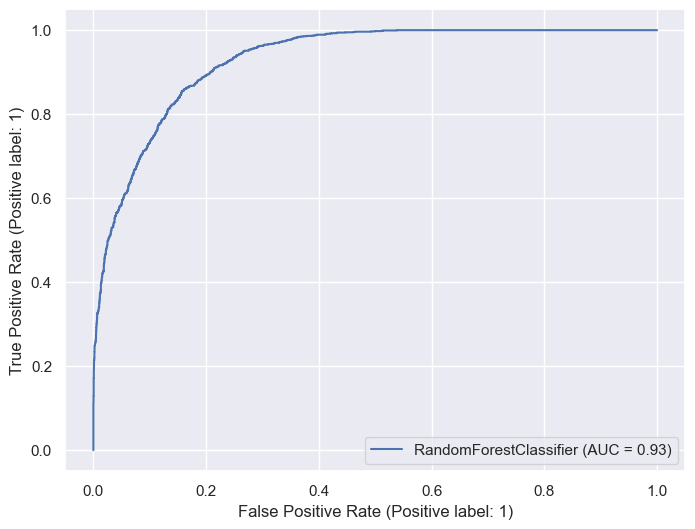

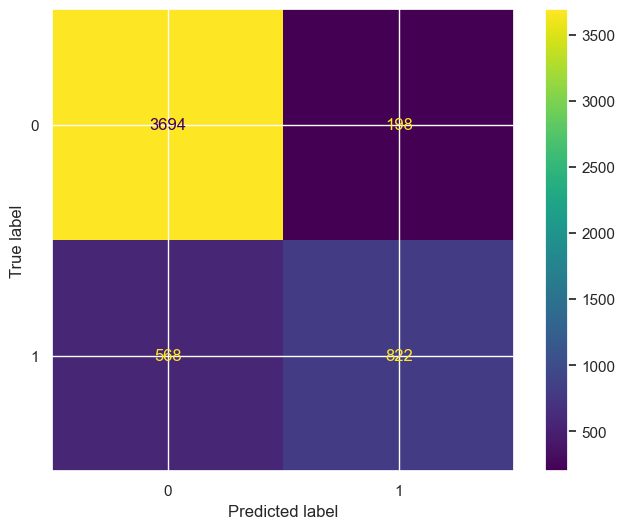

In [30]:
scoring(rfc_grid.best_estimator_, X_train, y_train)

Целевые метрики немного лучше

### CatBoost
Посмотрим на то, как справится бустинг.

Начнем с выделения категориальных признаков и создания Pool

In [31]:
X_train.columns

Index(['PaperlessBilling', 'MonthlyCharges', 'TotalCharges',
       'ContractDuration', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'MultipleLines', 'PhoneService',
       'Type_One year', 'Type_Two year',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'InternetService_Fiber optic', 'InternetService_No'],
      dtype='object')

In [32]:
param_grid = {'depth': [4, 6, 8, 10],
         'l2_leaf_reg': [1, 3, 5, 7, 9], 
         'learning_rate': [0.015, 0.03, 0.1],
         'iterations': [100, 500, 900, 1000]}

Теперь объявим параметры

In [33]:
cb = CatBoostClassifier(loss_function='Logloss',
              eval_metric='AUC',
              random_seed= 42,
              verbose=False,
              early_stopping_rounds=100,
              auto_class_weights='Balanced')

Переберем их

In [34]:
%%time
grid_search_result = cb.grid_search(param_grid,
                                        X=X_train,
                                        y=y_train,
                                        cv=5,
                                        partition_random_seed=42,
                                        refit=True,
                                        shuffle=True,
                                        stratified=None,
                                        verbose=False)


bestTest = 0.8387192251
bestIteration = 95

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.

bestTest = 0.8442985523
bestIteration = 99

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.

bestTest = 0.8548512646
bestIteration = 97

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.

bestTest = 0.8382158272
bestIteration = 99

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.

bestTest = 0.8434455724
bestIteration = 98

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.

bestTest = 0.8494164313
bestIteration = 95

Metric AUC is not calculated on train by default. To calcula

In [35]:
grid_search_result['params']

{'depth': 4, 'l2_leaf_reg': 5, 'iterations': 1000, 'learning_rate': 0.1}

Получили наилучший набор. Настроим модель заново с его учетом

In [36]:
cb = CatBoostClassifier(**grid_search_result['params'], 
                        loss_function='Logloss',
                        eval_metric='AUC',
                        random_seed= 42,
                        verbose=False,
                        early_stopping_rounds=100,
                        auto_class_weights='Balanced')
cb.fit(train_data)

Accuracy = 0.94


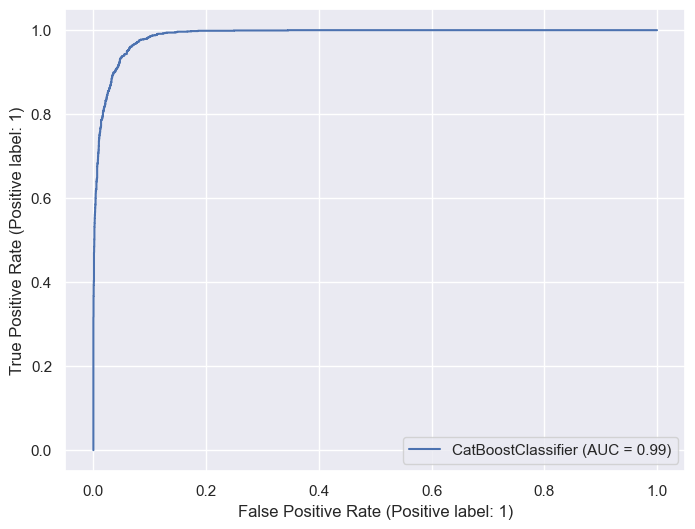

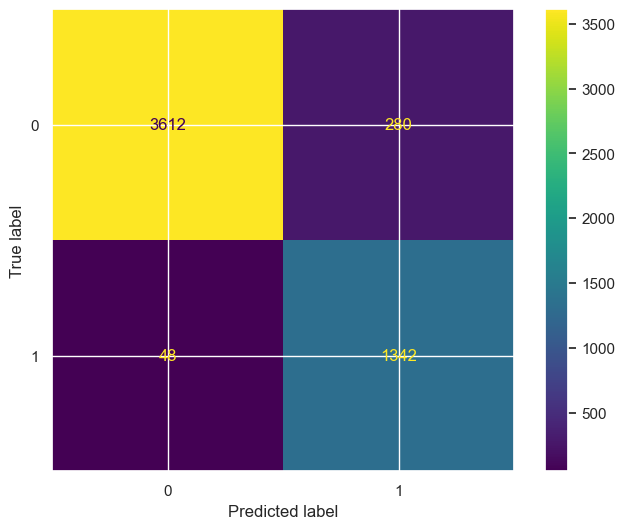

In [37]:
scoring(cb, X_train, y_train)

Впечатляюще! Ну что же, пойдем на тест с кэтбустом.

### CatBoost на самых важных фичах
Попробуем оставить только `ContractDuration`, `MonthlyCharges`, `TotalCharges`, `InternetService_Fiber optic`, `Type_Two year`

In [46]:
X_train_cropped = X_train[['ContractDuration', 'MonthlyCharges', 'TotalCharges', 'InternetService_Fiber optic', 'Type_Two year']]
X_test_cropped = X_test[['ContractDuration', 'MonthlyCharges', 'TotalCharges', 'InternetService_Fiber optic', 'Type_Two year']]

param_grid_fi = {'depth': [4, 6, 8, 10],
         'l2_leaf_reg': [1, 3, 5, 7, 9], 
         'learning_rate': [0.015, 0.03, 0.1],
         'iterations': [100, 500, 900, 1000]}

cb_important = CatBoostClassifier(loss_function='Logloss',
              eval_metric='AUC',
              random_seed= 42,
              verbose=False,
              early_stopping_rounds=100,
              auto_class_weights='Balanced')

In [39]:
%%time
grid_search_result_fi = cb_important.grid_search(param_grid_fi,
                                        X=X_train_cropped,
                                        y=y_train,
                                        cv=5,
                                        partition_random_seed=42,
                                        refit=True,
                                        shuffle=True,
                                        stratified=None,
                                        verbose=False)


bestTest = 0.8247196353
bestIteration = 99

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.

bestTest = 0.8335407519
bestIteration = 98

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.

bestTest = 0.850567721
bestIteration = 99

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.

bestTest = 0.8246077691
bestIteration = 99

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.

bestTest = 0.8299633638
bestIteration = 88

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.

bestTest = 0.8482418361
bestIteration = 98

Metric AUC is not calculated on train by default. To calculat

In [40]:
cb_important = CatBoostClassifier(**grid_search_result_fi['params'], 
                        loss_function='Logloss',
                        eval_metric='AUC',
                        random_seed= 42,
                        verbose=False,
                        early_stopping_rounds=100,
                        auto_class_weights='Balanced')
cb_important.fit(X_train_cropped, y_train)

Accuracy = 0.94


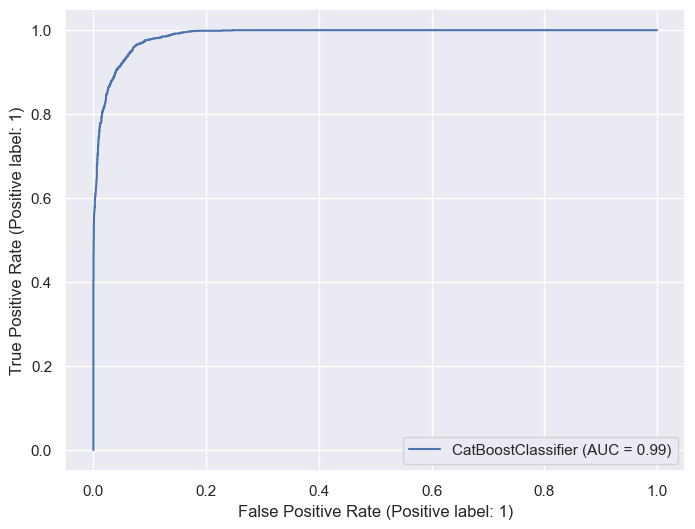

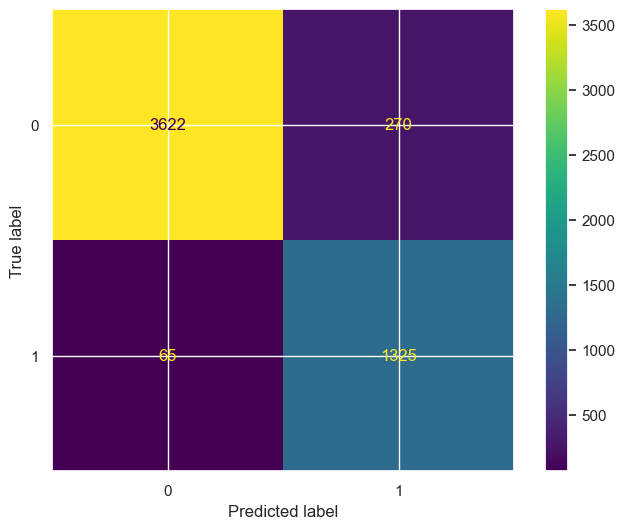

In [41]:
scoring(cb_important, X_train_cropped, y_train)

Разницы нет. Возьмем на тест обе модели

## Тестирование
### Catboost
Узнаем насколько хороша наша модель на тестовых данных. Кроме ROC-AUC, выведем для нее еще Accuracy, а также confusion matrix.

Accuracy = 0.88


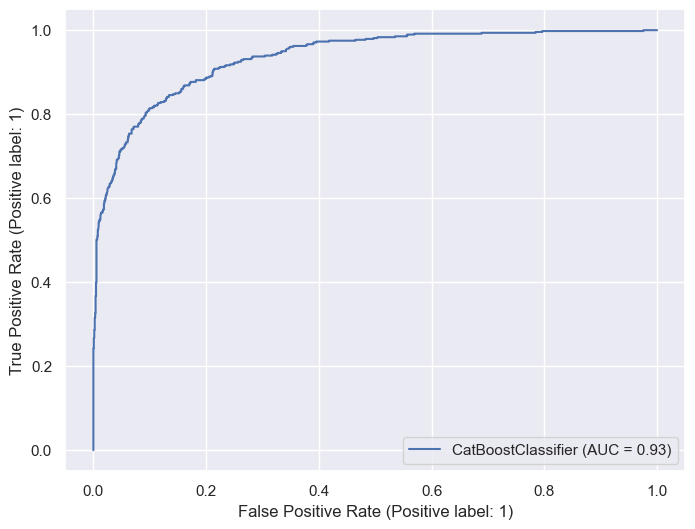

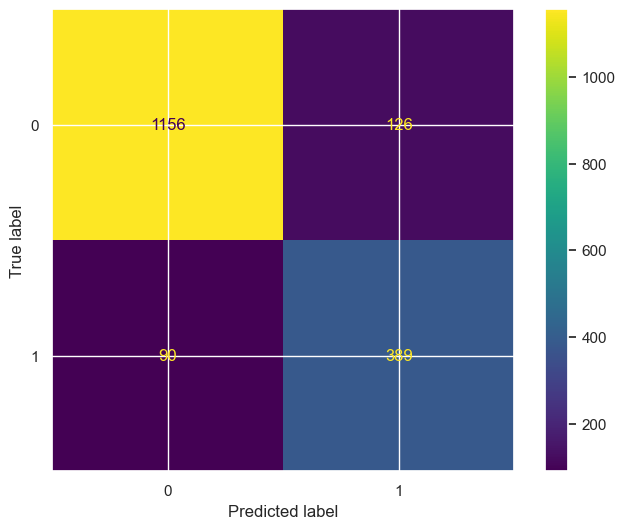

In [42]:
scoring(cb, X_test, y_test)

Целевая метрика достигнута!

### CatBoost на самых важных фичах

Accuracy = 0.88


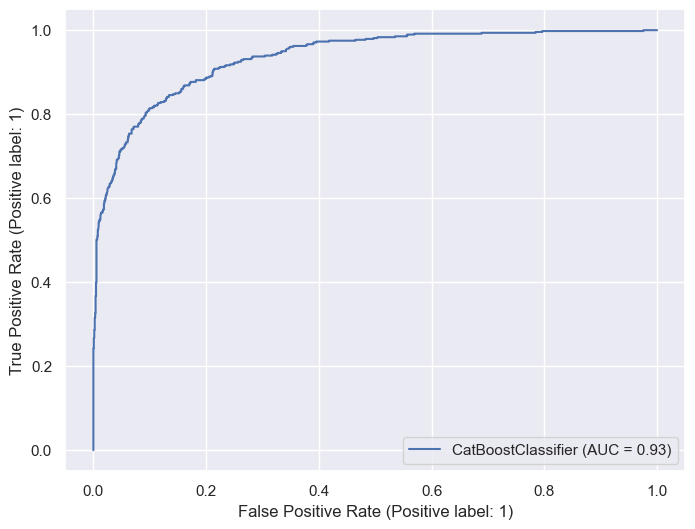

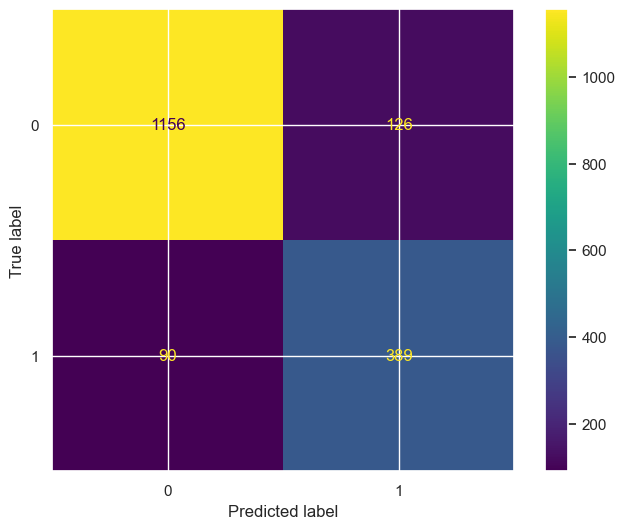

In [47]:
scoring(cb_important, X_test_cropped, y_test)

И снова никакой разницы

## Выводы
На тренировочных данных наилучший результат `0.99` по метрике ROC-AUC достигнут при помощи классификатора от catboost. На тестовых данных был достигнут результат `0.93`, accuracy при этом составила `0.88`. 

Если смотреть на матрицу ошибок, выходит, что отток прогнозируется корректно в четырех случаях из пяти, а вот ложноотрицательный результат встречается гораздо реже, примерно в каждом восьмом случае.